In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/CDV/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/CDV


In [7]:
from tools.misc_tools import create_CDV_data, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_cdv, plot_latent_states_cdv, readAndReturnLossHistories
from tools.ae_v3 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
tf.test.gpu_device_name()

2022-10-18 20:51:26.465480: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 20:51:26.683147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:26.683403: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:26.720113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

'/device:GPU:0'

evice: 1, name: Quadro K2200, pci bus id: 0000:03:00.0, compute capability: 5.0


# CDV System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # simutlation paramaters
    params_mat = np.array([
        [0.95, -0.76095, 0.1, 1.25, 0.2, 0.5],
        [0.99, -0.801*0.99, 0.1, 1.25, 0.2, 0.5]
    ])

#     init_state = [0.5]*6

    init_state = [0.9, 0.2, -0.1, -0.5, -0.2, 0.2]

    t0 = 0.0
    T = 2000.0
    delta_t = 0.1

    return_params_arr = False
    normalize_flag = True

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')

    # saving sim data
    sim_data = {
        'params_mat':params_mat,
        'init_state':init_state,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'normalize_flag':normalize_flag
    }
    with open(dir_name_ae+dir_sep+'sim_data_params.txt', 'w') as f:
        f.write(str(sim_data))

else:
    # simutlation paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_005'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'sim_data_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))

    params_mat = params_dict['params_mat']

    init_state = params_dict['init_state']

    t0 = params_dict['t0']
    T = params_dict['T']
    delta_t = params_dict['delta_t']

    return_params_arr = params_dict['return_params_arr']
    normalize_flag = params_dict['normalize_flag']

In [12]:
res_dict = create_CDV_data(
    T, t0, delta_t,
    params_mat,
    init_state, return_params_arr=return_params_arr,
    normalize=normalize_flag
)

all_data = res_dict['all_data']
N = res_dict['N']
boundary_idx_arr = res_dict['boundary_idx_arr']
params_arr = res_dict['params_arr']
normalization_constant_arr = res_dict['normalization_constant_arr']

In [13]:
# normalization_constant_arr

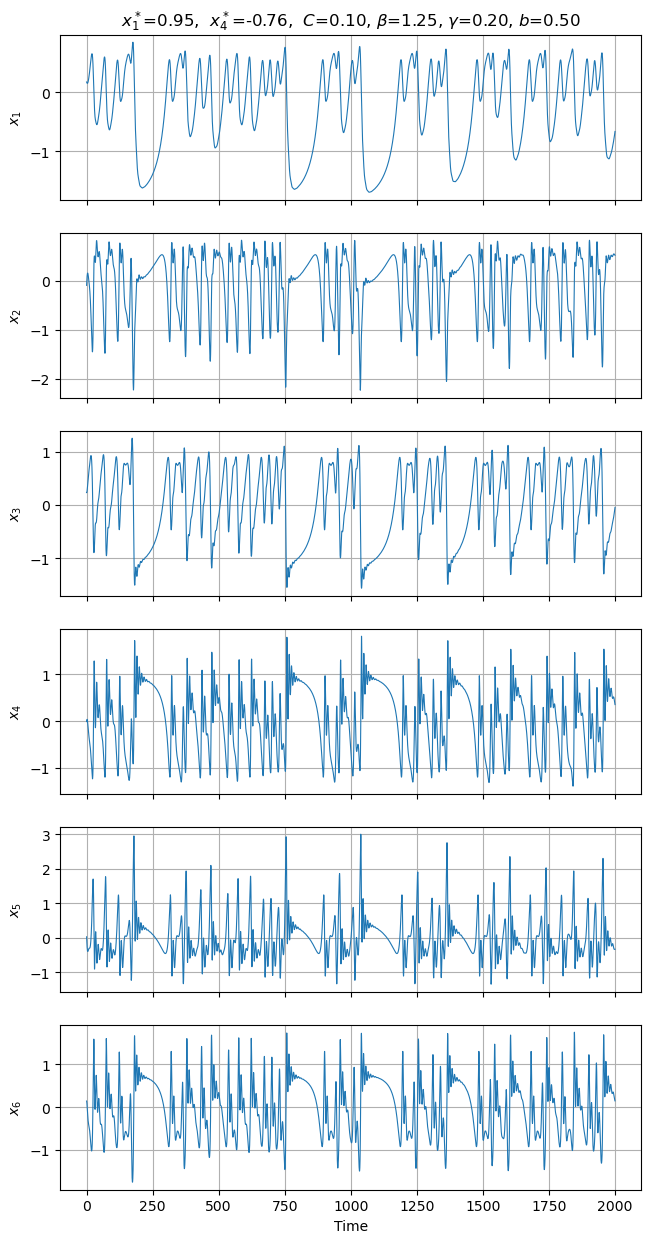

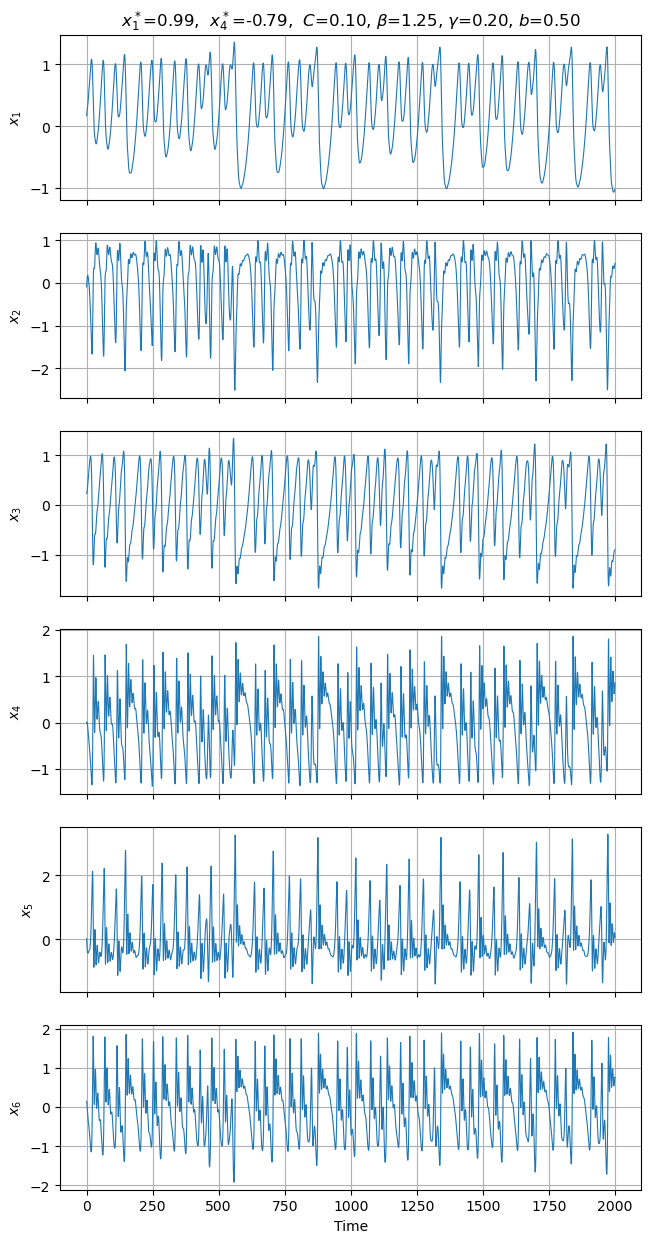

In [14]:
n = len(boundary_idx_arr)
# '''
num_cols = 1
num_rows = 6

factor = 1
# fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

prev_idx = 0
for i in range(len(boundary_idx_arr)):
    fig, ax = plt.subplots(6, 1, sharex=True, figsize=(factor*7.5*num_cols, factor*2.5*num_rows))
    ax_ylabels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$']
    input_time = np.arange(0, N+1)*delta_t
    for j in range(6):
        ax[j].plot(input_time, all_data[i*(N+1):(i+1)*(N+1), j], linewidth=0.8)#, label='_nolegend_')
        ax[j].grid()
        ax[j].set_ylabel(ax_ylabels[j])
        
    ax[0].set_title(r'$x_1^*$={:.2f},  $x_4^*$={:.2f},  $C$={:.2f}, $\beta$={:.2f}, $\gamma$={:.2f}, $b$={:.2f}'.format(
        all_data[i*(N+1), 6],
        all_data[i*(N+1), 7],
        all_data[i*(N+1), 8],
        all_data[i*(N+1), 9],
        all_data[i*(N+1), 10],
        all_data[i*(N+1), 11]
    ))
    ax[-1].set_xlabel('Time')
    plt.show()
    print('')
# '''

# Autoencoder

In [15]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [0.001, 0.0001, 0.00001]
    epochs = 2000
    patience = 40  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-5  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [16]:
# setting up data
idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)
boundary = int(np.round((1-test_split)*all_data.shape[0]))
training_data = all_data[idx[0:boundary], :]
testing_data = all_data[idx[boundary:], :]

In [17]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    ae_net = Autoencoder(
        data_dim=12,
        enc_layers=[32,24,16,12,8,4],
        dec_layers=[4,8,12,16,24,32],
        latent_space_dim=4,
        lambda_reg=lambda_reg,
        reg_name='L2',
        enc_layer_act_func='elu',
        enc_final_layer_act_func='tanh',
        dec_layer_act_func='elu',
        dec_final_layer_act_func='linear',
        load_file=None)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    ae_net = Autoencoder(data_dim=12, load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
    ae_net.load_weights_from_file(wt_file)

2022-10-18 20:51:40.241731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:40.242165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:40.242551: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:40.242908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 20:51:40.243253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [19]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    run_eagerly=False
)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=5  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=5)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
            validation_split=val_split/train_split,
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/2000
493/493 [==============================] - 5s 7ms/step - loss: 0.0781 - val_loss: 0.0199
Epoch 2/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0170 - val_loss: 0.0102
Epoch 3/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 4/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 5/2000
488/493 [============================>.] - ETA: 0s - loss: 0.0064 - tot_time: 0h 0m 18.1s

Epoch 5: val_loss improved from inf to 0.00599, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoi

493/493 [==============================] - 3s 7ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 34/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 35/2000
479/493 [============================>.] - ETA: 0s - loss: 0.0023 - tot_time: 0h 1m 53.4s

Epoch 35: val_loss improved from 0.00351 to 0.00220, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 36/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 37/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 38/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 39/2000
493/493 [==========

Epoch 66/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 67/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 68/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 69/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 70/2000
489/493 [============================>.] - ETA: 0s - loss: 0.0014 - tot_time: 0h 3m 47.2s

Epoch 70: val_loss improved from 0.00143 to 0.00143, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 71/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 72/2000
493/4

Epoch 101/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 102/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 103/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 104/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 105/2000
492/493 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 5m 39.8s

Epoch 105: val_loss did not improve from 0.00125
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 106/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 107/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 108/

Epoch 137/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 138/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 139/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 140/2000
490/493 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 7m 33.2s

Epoch 140: val_loss did not improve from 0.00121
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 141/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 142/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 143/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 144/

493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 173/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 174/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 175/2000
486/493 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 9m 25.8s

Epoch 175: val_loss did not improve from 0.00117
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 176/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 177/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 178/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 179/2000
493/493 [=

Epoch 207/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 208/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 209/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 210/2000
491/493 [============================>.] - ETA: 0s - loss: 0.0012 - tot_time: 0h 11m 19.0s

Epoch 210: val_loss did not improve from 0.00115
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 211/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 212/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 213/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 214

493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 243/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 244/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 245/2000
490/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 13m 12.3s

Epoch 245: val_loss did not improve from 0.00113
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 246/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 247/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 248/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 249/2000
493/493 [

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 16/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 17/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 18/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 19/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 20/2000
491/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 15m 4.6s

Epoch 20: val_loss did not improve from 0.00111
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 21/2000

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 51/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 52/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 53/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 54/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 55/2000
488/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 16m 58.3s

Epoch 55: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 56/200

493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 87/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 88/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 89/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 90/2000
489/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 18m 54.1s

Epoch 90: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 91/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 92/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 93/2000
493/493 [========

Epoch 121/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 122/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 123/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 124/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 125/2000
493/493 [==============================] - ETA: 0s - loss: 0.0011 - tot_time: 0h 20m 51.1s

Epoch 125: val_loss improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 126/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 127/2

Epoch 156/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 157/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 158/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 159/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 160/2000
490/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 22m 47.7s

Epoch 160: val_loss did not improve from 0.00110
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 161/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 162/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 163

Epoch 192/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 193/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 194/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 195/2000
491/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 24m 45.0s

Epoch 195: val_loss improved from 0.00110 to 0.00110, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 196/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 197/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 198/2

Epoch 227/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 228/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 229/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 230/2000
484/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 26m 42.0s

Epoch 230: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 231/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 232/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 233/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 234

493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 262/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 263/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 264/2000
493/493 [==============================] - 3s 6ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 265/2000
492/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 28m 39.8s

Epoch 265: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 266/2000
493/493 [==============================] - 4s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 267/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 268/2000
493/493 [

Epoch 296/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 297/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 298/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 299/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 300/2000
488/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 30m 37.4s

Epoch 300: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 301/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 302/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 303

Epoch 332/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 333/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 334/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 335/2000
492/493 [============================>.] - ETA: 0s - loss: 0.0011Restoring model weights from the end of the best epoch: 295.
 - tot_time: 0h 32m 34.0s

Epoch 335: val_loss did not improve from 0.00109
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 335: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 31/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 32/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 33/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 34/2000
493/493 [==============================] - 3s 7ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 35/2000
491/493 [============================>.] - ETA: 0s - loss: 0.0011 - tot_time: 0h 34m 30.4s

Epoch 35: val_loss improved from 0.00109 to 0.00109, saving model to /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/CDV/saved_ae/ae_010/checkpoints/LossHistoriesCheckpoint

In [20]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_loss = ae_net.evaluate(
        testing_data, testing_data,
    )

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_loss
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

125/125 [==============================] - 1s 4ms/step - loss: 0.0011


In [21]:
lr_change

[0, 260, 595, 636]

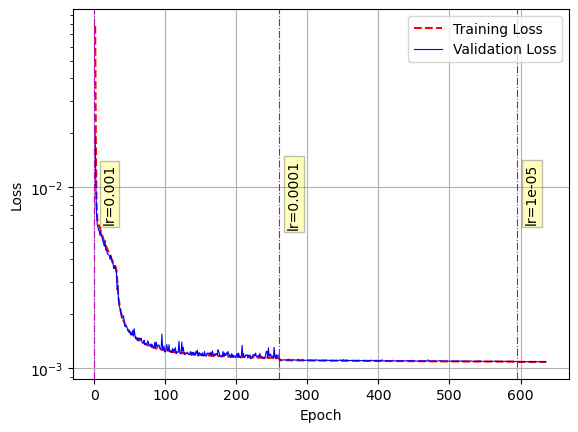

In [22]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [23]:
reconstructed_data = ae_net.predict(all_data)

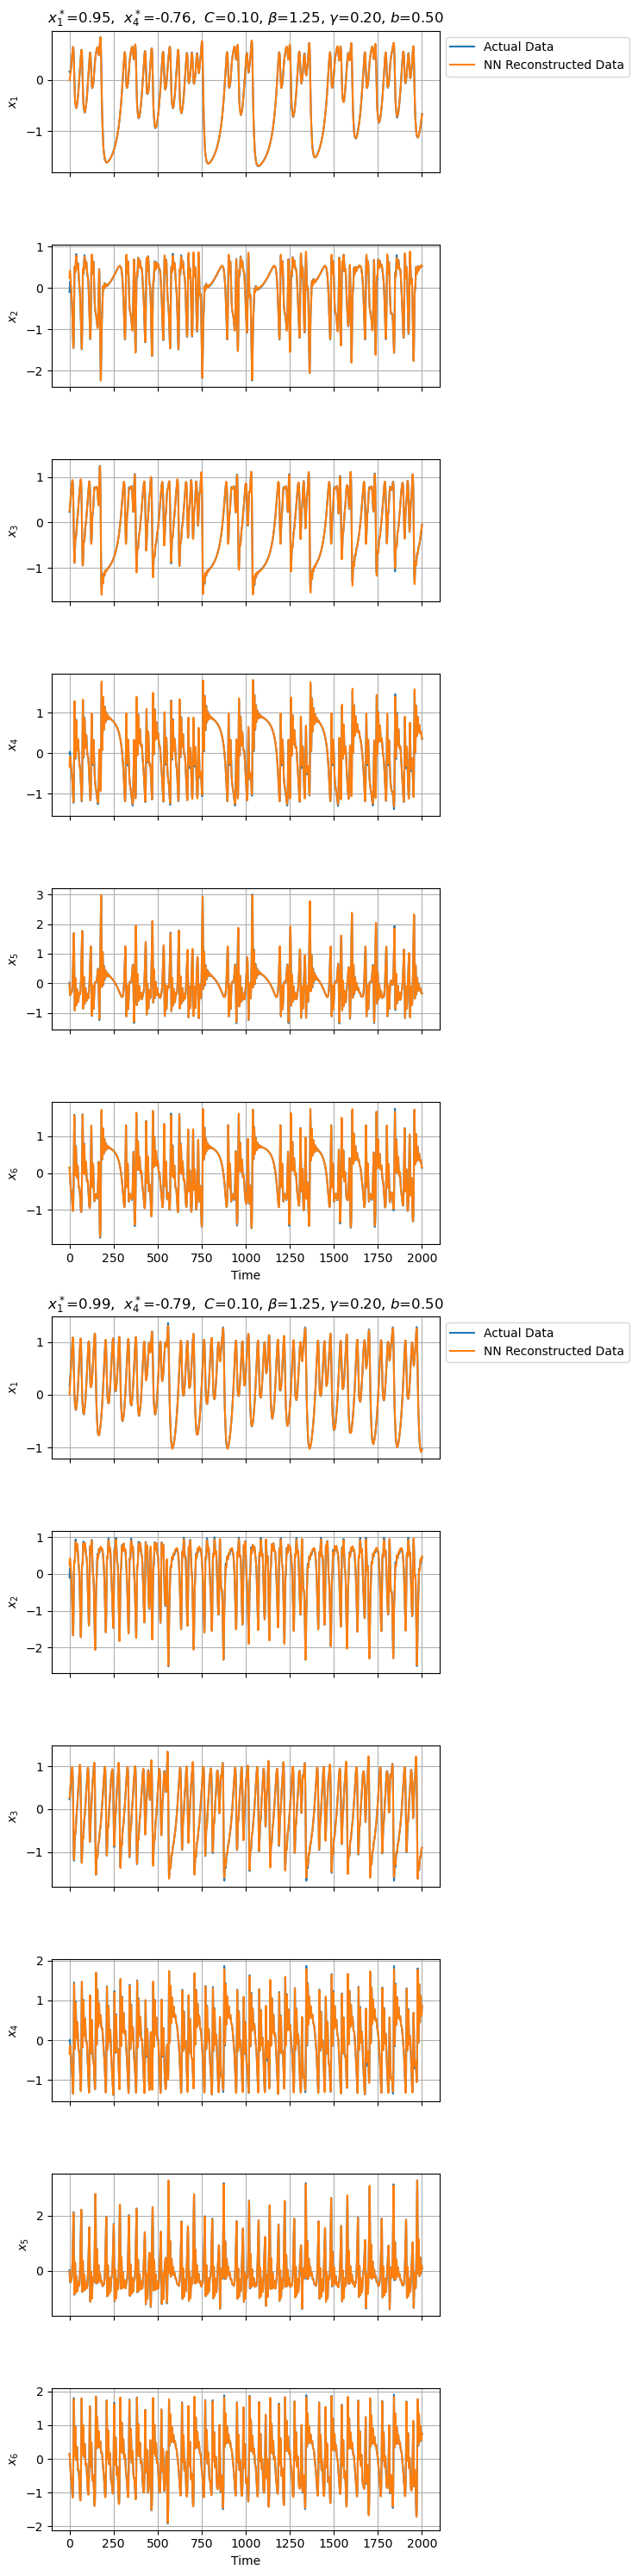

In [24]:
fig = plot_reconstructed_data_cdv(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    delta_t=delta_t,
    save_figs=False)

In [25]:
plot_reconstructed_data_cdv(
    boundary_idx_arr=boundary_idx_arr,
    dir_name_ae=dir_name_ae,
    all_data=all_data,
    reconstructed_data=reconstructed_data,
    delta_t=delta_t,
    save_figs=True)

In [26]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

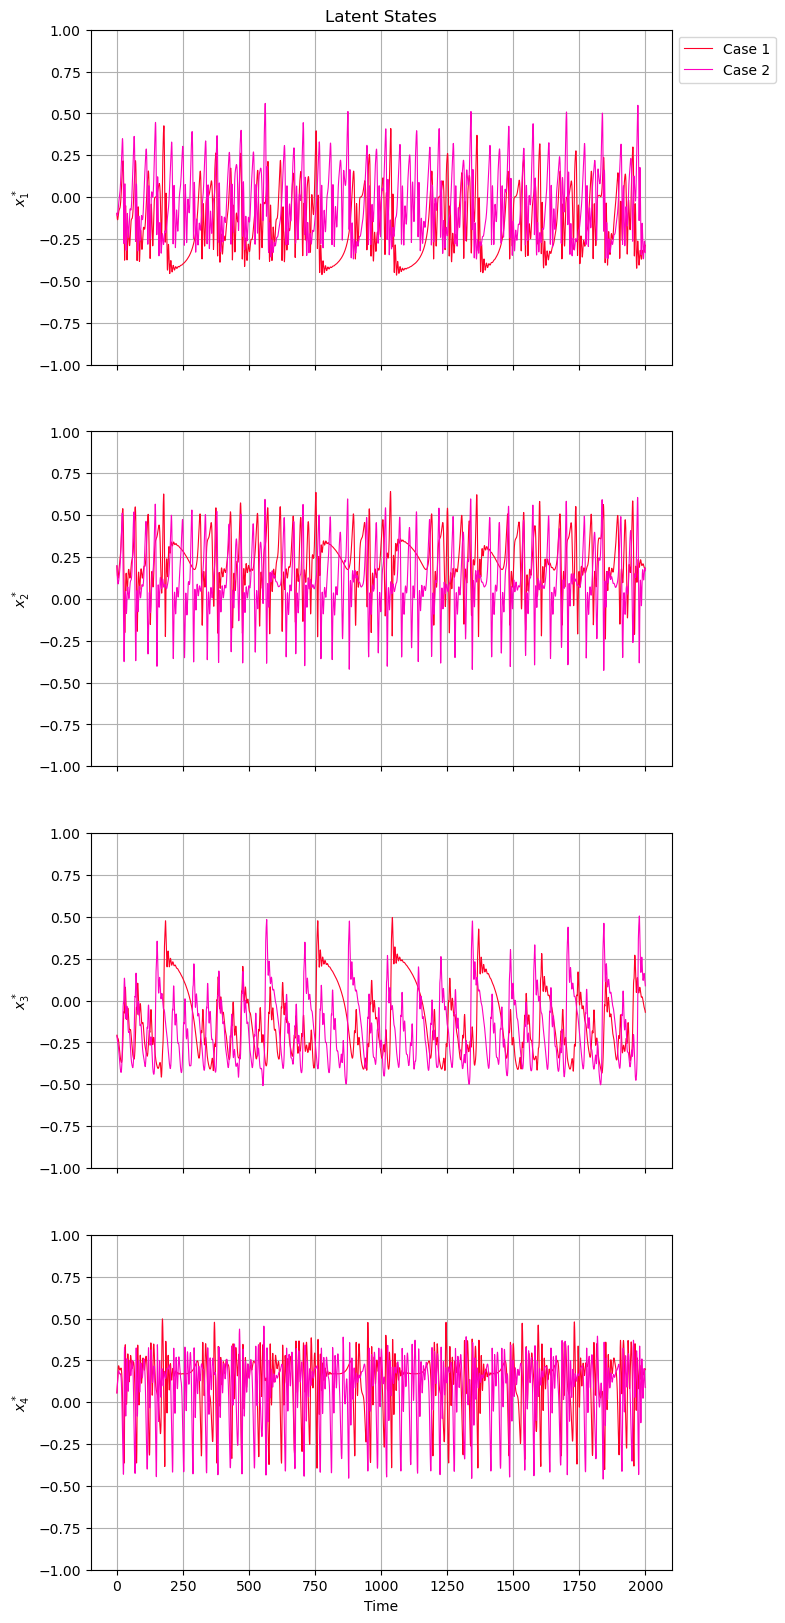

In [27]:
fig, ax = plot_latent_states_cdv(
    boundary_idx_arr,
    latent_states_all,
    all_data,
    delta_t,
    params_mat,
    # xlim=[-1,1],
    ylim=[-1,1],
    cmap_name='gist_rainbow',
    legend_markerscale=10,
    legend_bbox_to_anchor=[1,1],
    save_config_path=dir_name_ae + '{ds}plots'.format(ds=dir_sep)
)

plt.savefig(dir_name_ae + '{ds}plots{ds}latent_space.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')

In [28]:
# ae_net.summary()

# LSTM